In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # [PERBAIKAN] Tambahkan SMOTE
import pickle

In [2]:
# 1. Membaca dffish
dffish = pd.read_csv('fish_data.csv') 
dffish # Sesuaikan path jika perlu


,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31
...,...,...,...,...
4075,Sillaginopsis panijus,30.56,6.12,0.20
4076,Sillaginopsis panijus,29.66,6.11,0.21
4077,Sillaginopsis panijus,32.81,6.25,0.19
4078,Sillaginopsis panijus,29.78,6.11,0.21


In [3]:
# 2. Informasi dffish
print("dffishFrame Info:")
dffish.info()

dffishFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   species    4080 non-null   object 
 1   length     4080 non-null   float64
 2   weight     4080 non-null   float64
 3   w_l_ratio  4080 non-null   float64
dtypes: float64(3), object(1)
memory usage: 127.6+ KB



mengetahui jumlah data yang dari setiap label

In [4]:
dffish['species'].value_counts()

species
Setipinna taty            480
Anabas testudineus        476
Pethia conchonius         475
Otolithoides biauritus    468
Polynemus paradiseus      458
Sillaginopsis panijus     455
Otolithoides pama         435
Puntius lateristriga      418
Coilia dussumieri         415
Name: count, dtype: int64

mengetahui jumlah label dan  apa aja labelnya + type data

In [5]:
pd.unique(dffish['species'])

array(['Anabas testudineus', 'Coilia dussumieri',
       'Otolithoides biauritus', 'Otolithoides pama', 'Pethia conchonius',
       'Polynemus paradiseus', 'Puntius lateristriga', 'Setipinna taty',
       'Sillaginopsis panijus'], dtype=object)

In [6]:
print("\nDeskripsi dffish:")
print(dffish.describe())


Deskripsi dffish:
            length       weight    w_l_ratio
count  4080.000000  4080.000000  4080.000000
mean     17.353544     3.739875     0.252782
std       7.114684     1.040365     0.123046
min       6.360000     2.050000     0.080000
25%      11.327500     3.070000     0.170000
50%      17.350000     3.310000     0.190000
75%      22.585000     4.100000     0.340000
max      33.860000     6.290000     0.640000


In [7]:
# Memeriksa missing values
if dffish.isnull().sum().sum() > 0:
    print("Terdapat missing values, silakan bersihkan dffish terlebih dahulu.")
else:
    print("Tidak ada missi")

Tidak ada missi


In [8]:
# 3. Preprocessing dffish
x = dffish.drop(columns=['species'])
y = dffish['species']

In [9]:
# 4. Encoding Target
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([0, 0, 0, ..., 8, 8, 8])

In [10]:
# 5. Scaling Fitur
scaler = StandardScaler()
x = scaler.fit_transform(x)
x

array([[-0.9409222 , -0.27866241,  0.54635083],
       [-1.46806569, -0.45169987,  1.76555488],
       [-1.26142544, -0.26904922,  1.27787326],
       ...,
       [ 2.17273871,  2.41303142, -0.51029267],
       [ 1.74680677,  2.27844673, -0.34773214],
       [ 2.00545851,  2.3072863 , -0.51029267]])

In [11]:
# Oversampling dengan SMOTE (jika dffish tidak seimbang)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

In [12]:
# 6. Membagi dffish Training dan Testing
# 4. Split dffish
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [13]:
# 5. Hyperparameter Tuning (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2']
}

random_forest_model = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(
    estimator=random_forest_model,
    param_grid=param_grid,
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted',
    cv=5
)

print("Sedang mencari parameter terbaik...")
grid_search.fit(X_train, y_train)

print("\nHasil GridSearch:")
print(f"Skor terbaik: {grid_search.best_score_:.4f}")
print("Parameter terbaik:")
best_params = grid_search.best_params_
for key, value in best_params.items():
    print(f"  - {key}: {value}")

random_forest = grid_search.best_estimator_

Sedang mencari parameter terbaik...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Hasil GridSearch:
Skor terbaik: 0.9442
Parameter terbaik:
  - bootstrap: True
  - max_depth: 10
  - max_features: sqrt
  - min_samples_leaf: 1
  - min_samples_split: 5
  - n_estimators: 300


In [14]:
# 6. Evaluasi dengan Cross-Validation (Stratified K-Fold) [PERBAIKAN]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # [PERBAIKAN]
cv_scores = cross_val_score(random_forest, x, y, cv=skf, scoring='f1_weighted')  # [PERBAIKAN]
print(f"Rata-rata F1-Score CV (Stratified K-Fold): {cv_scores.mean() * 100:.2f}%")


Rata-rata F1-Score CV (Stratified K-Fold): 94.13%


In [15]:
# 7. Evaluasi pada dffish Uji
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00        77
           2       0.66      0.78      0.72        91
           3       1.00      1.00      1.00        86
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00       102
           6       1.00      1.00      1.00        65
           7       0.76      0.64      0.70       100
           8       1.00      1.00      1.00        86

    accuracy                           0.93       816
   macro avg       0.94      0.94      0.93       816
weighted avg       0.93      0.93      0.93       816

Akurasi Model: 93.14%


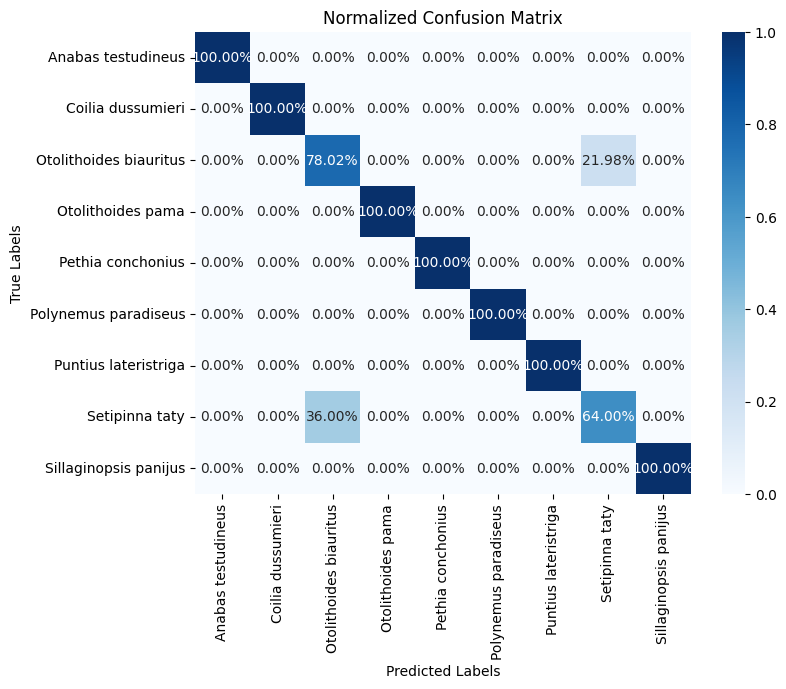

In [16]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Akurasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%")
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues',  # [PERBAIKAN]
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Normalized Confusion Matrix')  # [PERBAIKAN]
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
# 8. Menyimpan Model, Scaler, dan Encoder
with open('random_forest_fish.pkl', 'wb') as model_file:
    pickle.dump(random_forest, model_file)
with open('scaler_fish_forest.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
with open('label_encoder_fish_forest.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)

print("Model, scaler, dan encoder berhasil disimpan.")

Model, scaler, dan encoder berhasil disimpan.


In [18]:
# Memuat kembali model, scaler, dan encoder menggunakan pickle
with open('random_forest_fish.pkl', 'rb') as model_file:
    model = pickle.load(model_file)
with open('scaler_fish_forest.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)
with open('label_encoder_fish_forest.pkl', 'rb') as encoder_file:
    encoder = pickle.load(encoder_file)

In [19]:
def test_new_dffish(new_dffish):
    # Pastikan kolom dffish baru sesuai
    required_columns = ['length','weight','w_l_ratio']
    if not all(col in new_dffish.columns for col in required_columns):
        raise ValueError(f"dffish baru harus memiliki kolom: {required_columns}")
    # Skala dffish baru
    new_dffish_scaled = scaler.transform(new_dffish)
    # Prediksi
    predictions = random_forest.predict(new_dffish_scaled)
    return encoder.inverse_transform(predictions)

In [20]:

new_dffish = pd.DataFrame({
    'length': [5.5, 6.3],
    'weight': [120, 150],
    'w_l_ratio': [200, 180]   		
})

print("Prediksi untuk data baru:")
try:
    predictions = test_new_dffish(new_dffish)
    print(predictions)
except ValueError as e:
    print(f"Error: {e}")

Prediksi untuk data baru:
['Pethia conchonius' 'Pethia conchonius']
